In [14]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy import signal


`ELA11C_ADCread` function reads an ADC (Analog-to-Digital Converter) data file and processes its contents to extract magnetic field measurements in two dimensions, represented by arrays `Bx` and `By`. The function calculates the initial timestamp (`tini`) of the first sample based on the header information and the number of valid samples (`nr`) read from the file.

In [15]:
def ELA11C_ADCread(fn):
    f = open(fn, 'rb')
    header = np.fromfile(f, np.uint8, count=64)

    first_sample = int(header[48]) * 256 + int(header[49])
    tini = first_sample / 1250e3
    tini = tini - 20e-6

    data = np.fromfile(f, np.uint8).astype(int)
    ld = len(data) - 64
    Bx = np.zeros(int(ld / 4), dtype=int)
    By = np.zeros(int(ld / 4), dtype=int)

    nr = 0
    i = 1
    for j in range(89):
        now1 = 256 * 256 * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
        now3 = 256 * 256 * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]

        Bx[nr] = now1
        By[nr] = now3

        nr += 1
        i += 5

    i += 2

    for n in range(8836):
        for j in range(102):
            now1 = 256 * 256 * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
            now3 = 256 * 256 * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]

            Bx[nr] = now1
            By[nr] = now3

            nr += 1
            i += 5

        i += 2

    for j in range(82):
        now1 = 256 * 256 * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
        now3 = 256 * 256 * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]

        Bx[nr] = now1
        By[nr] = now3

        nr += 1
        i += 5

    f.close()

    while Bx[nr] == 0 or By[nr] == 0:
        nr -= 1

    midADC = 2 ** 18 / 2
    Bx = Bx[:nr + 1] - midADC
    By = By[:nr + 1] - midADC

    return Bx, By, nr, tini

In [202]:
def read_dat_file(fn):
    # Read the file directly after skipping the header (64 bytes)
    with open(fn, 'rb') as f:
        f.seek(64)
        data = np.fromfile(f, np.uint8).astype(int)
        
    ld = len(data)
    Bx = np.zeros(int(ld / 4), dtype=int)
    By = np.zeros(int(ld / 4), dtype=int)

    a = 65536
    nr = 0
    i = 1
    for j in range(89):
        Bx[nr] = a * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
        By[nr] = a * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]
        nr += 1
        i += 5

    i += 2

    for n in range(8836):
        for j in range(102):
            Bx[nr] = a * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
            By[nr] = a * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]
            nr += 1
            i += 5

        i += 2

    for j in range(82):
        Bx[nr] = a * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
        By[nr] = a * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]
        nr += 1
        i += 5

    while Bx[nr] == 0 or By[nr] == 0:
        nr -= 1

    midADC = 2 ** 18 / 2
    Bx = Bx[:nr + 1] - midADC
    By = By[:nr + 1] - midADC

    return Bx, By, nr, tini

In [183]:
# # Combined loop
# for phase, iterations in [(89, 1), (102, 8836), (82, 1)]:
#     for n in range(iterations):
#         for j in range(phase):
#             Bx[nr] = a * ((data[i] & 12) // 4) + data[i + 1] * 256 + data[i + 2]
#             By[nr] = a * (data[i] & 3) + data[i + 3] * 256 + data[i + 4]
#             nr += 1
#             i += 5
#         i += 2  # Increment i by 2 after each phase block


`calibrate_HYL` function calibrates the magnetic field measurements obtained from the `ELA11C_ADCread` function. It applies a conversion coefficient to transform the ADC readings from volts to picoteslas (pT).

In [16]:
def calibrate_HYL(Bx, By):
    a1_mVnT = 55.0  # [mV/nT] conversion coefficient
    a2_mVnT = 55.0  # [mV/nT] 

    a1 = a1_mVnT * 1e-3 / 1e3  # [V/pT]
    a2 = a2_mVnT * 1e-3 / 1e3  # [V/pT]
    ku = 4.26  # amplification in the receiver
    c1 = a1 * ku  # system sensitivity
    c2 = a2 * ku  # system sensitivity
    d = 2 ** 18  # 18-bit digital-to-analog converter
    V = 4.096 * 2  # [V] voltage range of digital-to-analog converter

    scale1 = c1 * d / V
    scale2 = c2 * d / V

    return -Bx / scale1, -By / scale2  # [pT] 

In [55]:
# Get PSD of the time-domain NS & EW signals
def compute_PSD(HNS, HEW, frequency, fmin, fmax):
    M = int(20 * frequency)  # 20-sec
    overlap = M // 2
    
    f, S_NS = signal.welch(HNS, fs=frequency, nperseg=M, noverlap=overlap, scaling='spectrum')
    f, S_EW = signal.welch(HEW, fs=frequency, nperseg=M, noverlap=overlap, scaling='spectrum')
    
    S_NS = S_NS / (f[1] - f[0])
    S_EW = S_EW / (f[1] - f[0])
    S_NS = S_NS[(f > fmin) & (f < fmax)]
    S_EW = S_EW[(f > fmin) & (f < fmax)]
    f = f[(f > fmin) & (f < fmax)]
    
    return S_NS, S_EW, f

In [53]:
def decimate_signal(HNS, HEW, downsampling_factor):
    len_HNS = len(HNS) - (len(HNS) % downsampling_factor)
    len_HEW = len(HEW) - (len(HEW) % downsampling_factor)
    HNS_downsampled = np.mean(HNS[:len_HNS].reshape(-1, downsampling_factor), axis=1).astype(int)
    HEW_downsampled = np.mean(HEW[:len_HEW].reshape(-1, downsampling_factor), axis=1).astype(int)
    return HNS_downsampled, HEW_downsampled


DAT file size: 4.32 MB, Samples: 901442, Initial Frequency: 3004.81 Hz
Time to read: 1.9854 seconds
Time to calibrate: 0.0026 seconds
Time to decimate signals: 0.0029 seconds
Time to compute downsampled PSD: 0.0053 seconds
Total time from dat file until decimated PSD: 1.9963 seconds, Decimated Frequency: 100.16 Hz


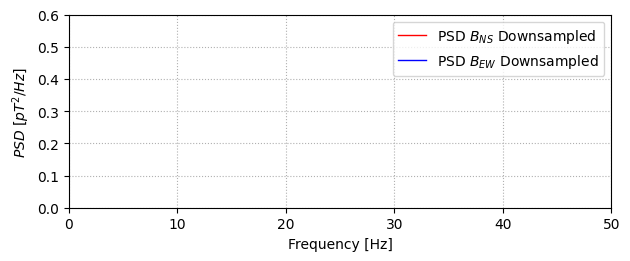

Time to plot: 0.1895 seconds


In [150]:
yymm = '202301'
dd = 6
hh = 0
folder = f"/media/vag/Users/echan/Documents/Parnon"
input_dat_file = f"{folder}/{yymm}{dd:02d}/{yymm}{dd:02d}{hh:02d}00.dat"

file_size_mb = os.path.getsize(input_dat_file) / (1024 * 1024)
initial_frequency = 5e6 / 128 / 13

# # Perform the experiment multiple times and average the results
# num_trials = 10
# times = []
# 
# for _ in range(num_trials):

start_reading = time.time()
HNS, HEW, nr, tini = ELA11C_ADCread(input_dat_file)
reading_time = time.time() - start_reading

start_calibrating = time.time()
HNS, HEW = calibrate_HYL(HNS, HEW)
calibration_time = time.time() - start_calibrating

print(f"\nDAT file size: {file_size_mb:.2f} MB, Samples: {nr}, Initial Frequency: {initial_frequency:.2f} Hz"
      f"\nTime to read: {reading_time:.4f} seconds"
      f"\nTime to calibrate: {calibration_time:.4f} seconds")

downsampling_factor = 30
decimated_frequency = initial_frequency / downsampling_factor
fmin = 3
fmax = 48

# Decimate the signals (HNS, HEW) with the given downsampling_factor
start_time = time.time()
HNS_downsampled, HEW_downsampled = decimate_signal(HNS, HEW, downsampling_factor)
decimate_time = time.time() - start_time

# Compute the PSD for the downsampled signals
start_time = time.time()
S_NS_downsampled, S_EW_downsampled, f_downsampled = compute_PSD(HNS_downsampled, HEW_downsampled, decimated_frequency, fmin, fmax)
compute_psd_time = time.time() - start_time
total_time = reading_time+calibration_time+decimate_time+compute_psd_time

print(f"Time to decimate signals: {decimate_time:.4f} seconds"
      f"\nTime to compute downsampled PSD: {compute_psd_time:.4f} seconds"
      f"\nTotal time from dat file until decimated PSD: {total_time:.4f} seconds, Decimated Frequency: {decimated_frequency:.2f} Hz")

# Plot PSD
start_time = time.time()
plt.subplot(2, 1, 2)
plt.plot(f_downsampled, S_NS_downsampled, 'r', lw=1, label='PSD $B_{NS}$ Downsampled')
plt.plot(f_downsampled, S_EW_downsampled, 'b', lw=1, label='PSD $B_{EW}$ Downsampled')
plt.ylabel(r"$PSD\ [pT^2/Hz]$")
plt.xlabel("Frequency [Hz]")
plt.xlim([0, 50])
plt.ylim([0, 0.6])
plt.grid(ls=':')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()
plot_time = time.time() - start_time
print(f"Time to plot: {plot_time:.4f} seconds")

# times.append(total_time)

# Calculate the averages
# avg_total_time = np.mean(times)
# avg_total_time

In [199]:
import sys

# Run both functions on the same input file
Bx_original, By_original, nr_original, tini_original = ELA11C_ADCread(input_dat_file)
Bx_optimized, By_optimized, nr_optimized, tini_optimized = read_dat_file(input_dat_file)

# Print the sizes of the arrays (number of elements and memory size)
print(f"Bx_original: Number of elements = {len(Bx_original)}, Memory size = {sys.getsizeof(Bx_original)} bytes")
print(f"By_original: Number of elements = {len(By_original)}, Memory size = {sys.getsizeof(By_original)} bytes")
print(f"Bx_optimized: Number of elements = {len(Bx_optimized)}, Memory size = {sys.getsizeof(Bx_optimized)} bytes")
print(f"By_optimized: Number of elements = {len(By_optimized)}, Memory size = {sys.getsizeof(By_optimized)} bytes")

# Print the size of the nr and tini variables
print(f"nr_original: {sys.getsizeof(nr_original)} bytes")
print(f"nr_optimized: {sys.getsizeof(nr_optimized)} bytes")
print(f"tini_original: {sys.getsizeof(tini_original)} bytes")
print(f"tini_optimized: {sys.getsizeof(tini_optimized)} bytes")

# Define the chunk size for comparison
chunk_size = 10

# Compare Bx arrays in chunks
print("\nComparing Bx arrays in chunks:")
for i in range(0, len(Bx_original)//1000, chunk_size):
    print(f"\nChunk {i // chunk_size}:")
    print(f"Bx_original[{i}:{i + chunk_size}]: {Bx_original[i:i + chunk_size]}")
    print(f"Bx_optimized[{i}:{i + chunk_size}]: {Bx_optimized[i:i + chunk_size]}")

# Compare By arrays in chunks
print("\nComparing By arrays in chunks:")
for i in range(0, len(By_original)//1000, chunk_size):
    print(f"\nChunk {i // chunk_size}:")
    print(f"By_original[{i}:{i + chunk_size}]: {By_original[i:i + chunk_size]}")
    print(f"By_optimized[{i}:{i + chunk_size}]: {By_optimized[i:i + chunk_size]}")


Bx_original: Number of elements = 901442, Memory size = 7211648 bytes
By_original: Number of elements = 901442, Memory size = 7211648 bytes
Bx_optimized: Number of elements = 901442, Memory size = 7211648 bytes
By_optimized: Number of elements = 901442, Memory size = 7211648 bytes
nr_original: 28 bytes
nr_optimized: 28 bytes
tini_original: 24 bytes
tini_optimized: 24 bytes

Comparing Bx arrays in chunks:

Chunk 0:
Bx_original[0:10]: [713. 717. 719. 719. 722. 722. 725. 727. 724. 721.]
Bx_optimized[0:10]: [713. 717. 719. 719. 722. 722. 725. 727. 724. 721.]

Chunk 1:
Bx_original[10:20]: [719. 722. 722. 719. 719. 716. 716. 714. 714. 719.]
Bx_optimized[10:20]: [719. 722. 722. 719. 719. 716. 716. 714. 714. 719.]

Chunk 2:
Bx_original[20:30]: [720. 721. 717. 718. 714. 706. 705. 702. 700. 700.]
Bx_optimized[20:30]: [720. 721. 717. 718. 714. 706. 705. 702. 700. 700.]

Chunk 3:
Bx_original[30:40]: [700. 702. 702. 704. 702. 697. 694. 688. 690. 688.]
Bx_optimized[30:40]: [700. 702. 702. 704. 702. 

In [203]:
import time
import numpy as np

# Assuming `ELA11C_ADCread` and `read_dat_file` are already defined

def compare_algorithms(input_dat_file, num_trials=10):
    times_original = []
    times_optimized = []
    
    for _ in range(num_trials):
        # Time the original algorithm
        start_time = time.time()
        Bx_original, By_original, nr_original, tini_original = ELA11C_ADCread(input_dat_file)
        end_time = time.time()
        times_original.append(end_time - start_time)
        
        # Time the optimized algorithm
        start_time = time.time()
        Bx_optimized, By_optimized, nr_optimized, tini_optimized = read_dat_file(input_dat_file)
        end_time = time.time()
        times_optimized.append(end_time - start_time)
    
    # Calculate average times
    avg_time_original = np.mean(times_original)
    avg_time_optimized = np.mean(times_optimized)

    # Display results
    print(f"Average time for original algorithm: {avg_time_original:.6f} seconds")
    print(f"Average time for optimized algorithm: {avg_time_optimized:.6f} seconds")

    # Optional: check if results are the same (Bx, By, nr, tini)
    identical_results = (
        np.array_equal(Bx_original, Bx_optimized) and
        np.array_equal(By_original, By_optimized) and
        nr_original == nr_optimized and
        np.isclose(tini_original, tini_optimized)
    )

    print(f"Are the results identical? {'Yes' if identical_results else 'No'}")

# Example usage
compare_algorithms(input_dat_file)


Average time for original algorithm: 0.949434 seconds
Average time for optimized algorithm: 0.845199 seconds
Are the results identical? Yes


Lorentzian

In [106]:
# Perform the experiment multiple times and average the results
num_trials = 10
times = []

for _ in range(num_trials):
    start_time = time.time()
    HNS, HEW, nr, tini = ELA11C_ADCread(input_dat_file)
    read_time = time.time() - start_time
    times.append(read_time)

# Calculate the averages
avg_read_time = np.mean(times)

In [107]:
avg_read_time

np.float64(1.3675494194030762)

In [75]:
f_downsampled

array([ 3.0003073,  3.0503123,  3.1003175,  3.1503227,  3.2003276,
        3.2503328,  3.300338 ,  3.350343 ,  3.4003482,  3.4503534,
        3.5003583,  3.5503635,  3.6003687,  3.6503737,  3.700379 ,
        3.750384 ,  3.800389 ,  3.8503942,  3.9003994,  3.9504044,
        4.0004096,  4.0504146,  4.10042  ,  4.150425 ,  4.20043  ,
        4.2504354,  4.3004403,  4.3504453,  4.4004507,  4.4504557,
        4.5004606,  4.550466 ,  4.600471 ,  4.650476 ,  4.7004814,
        4.7504864,  4.8004913,  4.850497 ,  4.9005017,  4.950507 ,
        5.000512 ,  5.050517 ,  5.1005225,  5.1505275,  5.2005324,
        5.250538 ,  5.300543 ,  5.350548 ,  5.400553 ,  5.450558 ,
        5.500563 ,  5.5505686,  5.6005735,  5.6505785,  5.700584 ,
        5.750589 ,  5.800594 ,  5.8505993,  5.9006042,  5.950609 ,
        6.0006146,  6.0506196,  6.1006246,  6.15063  ,  6.200635 ,
        6.25064  ,  6.3006454,  6.3506503,  6.4006553,  6.4506607,
        6.5006657,  6.5506706,  6.600676 ,  6.650681 ,  6.7006

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import time


# Perform the experiment multiple times and average the results
num_trials = 10
save_times = []
load_times = []
plot_times = []

for _ in range(num_trials):
    # Timing the saving process
    start_time = time.time()

    # Save the PSD data and frequency array into a .npz file
    np.savez_compressed('psd_data_downsampled.npz', 
                        # freq=f_downsampled, 
                        NS=S_NS_downsampled, 
                        EW=S_EW_downsampled)

    save_npz_time = time.time() - start_time
    save_times.append(save_npz_time)

    # Timing the loading process
    start_time = time.time()

    # Load the compressed .npz file
    data = np.load('psd_data_downsampled.npz')

    # Access the arrays
    # f_downsampled_npz = data['freq']
    S_NS_downsampled_npz = data['NS']
    S_EW_downsampled_npz = data['EW']

    load_npz_time = time.time() - start_time
    load_times.append(load_npz_time)

    # Timing the plotting process
    start_time = time.time()

    # Plot PSD from npz
    plt.subplot(2, 1, 2)
    plt.plot(f_downsampled, S_NS_downsampled_npz, 'r', lw=1, label='PSD $B_{NS}$ from npz')
    plt.plot(f_downsampled, S_EW_downsampled_npz, 'b', lw=1, label='PSD $B_{EW}$ from npz')
    plt.ylabel(r"$PSD\ [pT^2/Hz]$")
    plt.xlabel("Frequency [Hz]")
    plt.xlim([0, 50])
    plt.ylim([0, 0.6])
    plt.grid(ls=':')
    plt.legend()
    plt.tight_layout()
    plt.close()

    plot_npz_time = time.time() - start_time
    plot_times.append(plot_npz_time)

# Calculate the averages
save_npz_time = np.mean(save_times)
load_npz_time = np.mean(load_times)
plot_npz_time = np.mean(plot_times)
# Output the times
(save_npz_time, load_npz_time, plot_npz_time)

(np.float64(0.0012431144714355469),
 np.float64(0.0009560346603393555),
 np.float64(0.0844348669052124))

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import time
import zstandard as zstd
import io
# Perform the experiment multiple times and average the results

num_trials = 10
save_times = []
load_times = []
plot_times = []

for _ in range(num_trials):
    # Timing the saving process
    start_time = time.time()

    # Save the data in .zst format to a buffer
    buffer = io.BytesIO()
    np.savez(buffer, 
             # freq=f_downsampled, 
             NS=S_NS_downsampled, 
             EW=S_EW_downsampled)

    # Compress the buffer using zstandard
    compressed_data = zstd.ZstdCompressor(level=3).compress(buffer.getvalue())

    # Write the compressed data to a file
    with open('psd_data_downsampled.zst', 'wb') as f:
        f.write(compressed_data)

    save_zstd_time = time.time() - start_time
    save_times.append(save_zstd_time)

    # Timing the loading process
    start_time = time.time()

    # Read the compressed file
    with open('psd_data_downsampled.zst', 'rb') as f:
        compressed_data = f.read()

    # Decompress the data using zstandard
    decompressed_data = zstd.ZstdDecompressor().decompress(compressed_data)

    # Load the decompressed data into a numpy array
    buffer = io.BytesIO(decompressed_data)
    data = np.load(buffer)

    # Access the arrays
    # f_downsampled_zstd = data['freq']
    S_NS_downsampled_zstd = data['NS']
    S_EW_downsampled_zstd = data['EW']

    load_zstd_time = time.time() - start_time
    load_times.append(load_zstd_time)

    # Timing the plotting process
    start_time = time.time()

    # Plot PSD from the decompressed data
    plt.subplot(2, 1, 2)
    plt.plot(f_downsampled, S_NS_downsampled_zstd, 'r', lw=1, label='PSD $B_{NS}$ from zstd')
    plt.plot(f_downsampled, S_EW_downsampled_zstd, 'b', lw=1, label='PSD $B_{EW}$ from zstd')
    plt.ylabel(r"$PSD\ [pT^2/Hz]$")
    plt.xlabel("Frequency [Hz]")
    plt.xlim([0, 50])
    plt.ylim([0, 0.6])
    plt.grid(ls=':')
    plt.legend()
    plt.tight_layout()
    plt.close()

    plot_zstd_time = time.time() - start_time
    plot_times.append(plot_zstd_time)

# Calculate the averages
save_zstd_time = np.mean(save_times)
load_zstd_time = np.mean(load_times)
plot_zstd_time = np.mean(plot_times)

# Output the times
(save_zstd_time, load_zstd_time, plot_zstd_time)


(np.float64(0.000653076171875),
 np.float64(0.0007532596588134766),
 np.float64(0.0808936357498169))

In [78]:
import os

# Function to compare times and calculate the percentage difference
def compare_times(time_npz, time_lzma, label, alg_a, alg_b):
    if time_lzma > time_npz:
        diff_percent = ((time_lzma - time_npz) / time_npz) * 100
        result = f"{label}: {alg_b} is {diff_percent:.2f}% slower than {alg_a}"
    else:
        diff_percent = ((time_npz - time_lzma) / time_lzma) * 100
        result = f"{label}: {alg_a} is {diff_percent:.2f}% slower than {alg_b}"
    return result

# Compare save, load, and plot times
save_comparison = compare_times(save_npz_time, save_zstd_time, "Save Time", "npz", "zstd")
load_comparison = compare_times(load_npz_time, load_zstd_time, "Load Time", "npz", "zstd")
plot_comparison = compare_times(plot_npz_time, plot_zstd_time, "Plot Time", "npz", "zstd")

print(save_comparison, "\n", load_comparison, "\n", plot_comparison)

# Get the sizes
npz_file_size = os.path.getsize('psd_data_downsampled.npz')
lzma_file_size = os.path.getsize('psd_data_downsampled.zst')

# Calculate the percentage difference in file sizes
file_size_diff_percent = ((lzma_file_size - npz_file_size) / npz_file_size) * 100

# Create a more readable output
file_size_comparison = f"""
File Size Comparison:
- npz file size: {npz_file_size / 1024:.2f} KB
- zstd file size: {lzma_file_size / 1024:.2f} KB
- zstd is {abs(file_size_diff_percent):.2f}% smaller/bigger than npz
"""

print(file_size_comparison)


Save Time: npz is 90.35% slower than zstd 
 Load Time: npz is 26.92% slower than zstd 
 Plot Time: npz is 4.38% slower than zstd

File Size Comparison:
- npz file size: 6.68 KB
- zstd file size: 6.51 KB
- zstd is 2.51% smaller/bigger than npz



In [ ]:
# Sampling frequency (3kHz) and time step
sampling_freq = 5e6 / 128 / 13  # Hz
T = 1 / sampling_freq

# Perform Fourier Transform on one of the signals
HNS_fft = fft(HNS)
freqs = np.fft.fftfreq(len(HNS), T)

# Select one point per Hz
unique_hz_indices = []
unique_hz_values = set()

# Iterate through the frequency data to select one point per Hz
for i, freq in enumerate(freqs):
    hz_value = int(freq)  # Take the integer part of the frequency (Hz)
    if hz_value not in unique_hz_values and hz_value >= 0:
        unique_hz_values.add(hz_value)
        unique_hz_indices.append(i)
    if len(unique_hz_values) >= 50:  # Limit to 20 points for the fit
        break

xdata = freqs[unique_hz_indices]
ydata = np.abs(HNS_fft[unique_hz_indices])

# Define the sum of multiple Lorentzian functions
def sum_of_Lorentzians(x, A1, B1, C1, A2, B2, C2, A3, B3, C3, A4, B4, C4):
    return (A1 / (1 + B1 * (x - C1)**2) +
            A2 / (1 + B2 * (x - C2)**2) +
            A3 / (1 + B3 * (x - C3)**2) +
            A4 / (1 + B4 * (x - C4)**2))

# Create arrays to store the average frequency and amplitude per Hz
unique_hz_values = np.arange(3, int(max(xdata)) + 1)  # Only considering frequencies >= 3 Hz
avg_amplitudes = []

# Iterate through each Hz and calculate the average amplitude for all points within that Hz
for hz in unique_hz_values:
    indices = np.where((xdata >= hz) & (xdata < hz + 1))[0]  # Find indices corresponding to the current Hz range
    if len(indices) > 0:
        avg_amplitudes.append(np.mean(ydata[indices]))  # Compute the average amplitude

# Convert to numpy arrays for fitting
xdata_avg = unique_hz_values
ydata_avg = np.array(avg_amplitudes)

# Fit the sum of Lorentzians curve to the averaged data with initial guesses for parameters
p0 = [max(ydata_avg), 1, 10, max(ydata_avg)/2, 1, 20, max(ydata_avg)/3, 1, 30, max(ydata_avg)/4, 1, 40]  # Initial guesses
parameters, covariance = curve_fit(sum_of_Lorentzians, xdata_avg, ydata_avg, p0=p0, maxfev=5000)

# Extract fitted parameters
fit_params = parameters

# Generate fitted data using the sum of Lorentzians
fit_y = sum_of_Lorentzians(xdata_avg, *fit_params)

# Plot the averaged data and the Lorentzian fit
plt.plot(xdata_avg, ydata_avg, 'o', label='Average per Hz data')
plt.plot(xdata_avg, fit_y, '-', label='Sum of Lorentzians fit')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Print the fitted parameters
print(f'Fitted parameters: {fit_params}')


gaussian

In [ ]:
# Sampling frequency (3kHz) and time step
sampling_freq = 5e6 / 128 / 13  # Hz
T = 1 / sampling_freq

# Perform Fourier Transform on one of the signals
HNS_fft = fft(HNS)
freqs = np.fft.fftfreq(len(HNS), T)

# Select one point per Hz
unique_hz_indices = []
unique_hz_values = set()

# Iterate through the frequency data to select one point per Hz
for i, freq in enumerate(freqs):
    hz_value = int(freq)  # Take the integer part of the frequency (Hz)
    if hz_value not in unique_hz_values and hz_value >= 0:
        unique_hz_values.add(hz_value)
        unique_hz_indices.append(i)
    if len(unique_hz_values) >= 40:  # Limit to 20 points for the fit
        break

xdata = freqs[unique_hz_indices]
ydata = np.abs(HNS_fft[unique_hz_indices])

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the sum of multiple Gaussian functions
def sum_of_Gaussians(x, A1, B1, C1, A2, B2, C2, A3, B3, C3, A4, B4, C4):
    return (A1 * np.exp(-B1 * (x - C1)**2) +
            A2 * np.exp(-B2 * (x - C2)**2) +
            A3 * np.exp(-B3 * (x - C3)**2) +
            A4 * np.exp(-B4 * (x - C4)**2))

# Create arrays to store the average frequency and amplitude per Hz
unique_hz_values = np.arange(3, int(max(xdata)) + 1)  # Only considering frequencies >= 3 Hz
avg_amplitudes = []

# Iterate through each Hz and calculate the average amplitude for all points within that Hz
for hz in unique_hz_values:
    indices = np.where((xdata >= hz) & (xdata < hz + 1))[0]  # Find indices corresponding to the current Hz range
    if len(indices) > 0:
        avg_amplitudes.append(np.mean(ydata[indices]))  # Compute the average amplitude

# Convert to numpy arrays for fitting
xdata_avg = unique_hz_values
ydata_avg = np.array(avg_amplitudes)

# Fit the sum of Gaussians curve to the averaged data with initial guesses for parameters
p0 = [max(ydata_avg), 1, 10, max(ydata_avg)/2, 1, 20, max(ydata_avg)/3, 1, 30, max(ydata_avg)/4, 1, 40]  # Initial guesses
parameters, covariance = curve_fit(sum_of_Gaussians, xdata_avg, ydata_avg, p0=p0, maxfev=5000)

# Extract fitted parameters
fit_params = parameters

# Generate fitted data using the sum of Gaussians
fit_y = sum_of_Gaussians(xdata_avg, *fit_params)

# Plot the averaged data and the Gaussian fit
plt.plot(xdata_avg, ydata_avg, 'o', label='Average per Hz data')
plt.plot(xdata_avg, fit_y, '-', label='Sum of Gaussians fit')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Print the fitted parameters
print(f'Fitted parameters: {fit_params}')


In [ ]:
from scipy.fftpack import dct, idct

# Load the signal again, assuming two columns (North-South and East-West)
signal = np.loadtxt("./generated/202301060000.txt")

freq = 5e6 / 128 / 13
freq_down = freq / 30
# Separate the signals
north_south_signal = signal[:, 0]
east_west_signal = signal[:, 1]
t = np.linspace(0, len(north_south_signal)/freq_down, len(north_south_signal))

print(freq)
# Apply DCT to both signals
dct_ns = dct(north_south_signal, type=2, norm='ortho')
dct_ew = dct(east_west_signal, type=2, norm='ortho')

# Keep only the first N coefficients (for compression)
N_ns = int(0.1 * len(dct_ns))  # Keeping 10% of the coefficients for North-South
N_ew = int(0.1 * len(dct_ew))  # Keeping 10% of the coefficients for East-West

dct_ns[N_ns:] = 0
dct_ew[N_ew:] = 0

# Reconstruct the signals using inverse DCT
compressed_ns = idct(dct_ns, type=2, norm='ortho')
compressed_ew = idct(dct_ew, type=2, norm='ortho')

# Plot the original and compressed signals for both North-South and East-West
plt.figure(figsize=(12, 8))

# Plot both North-South and East-West signals in the same plot
plt.figure(figsize=(12, 6))

# Plot North-South signals (original and compressed)
plt.plot(t, north_south_signal, label='Original NS Signal', alpha=0.6)
plt.plot(t, compressed_ns, label='Compressed NS Signal (DCT)', linestyle='--')

# Plot East-West signals (original and compressed)
plt.plot(t, east_west_signal, label='Original EW Signal', alpha=0.6)
plt.plot(t, compressed_ew, label='Compressed EW Signal (DCT)', linestyle='--')

# Add labels, title, and limits
plt.title('North-South and East-West: Original vs DCT Compressed Signals')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim([-200, 0])
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Combine the compressed North-South and East-West signals into a two-column format
compressed_signals = np.column_stack((compressed_ns, compressed_ew))
# Convert the compressed signals to integers
compressed_signals_int = compressed_signals.astype(int)

# Save the integer compressed signal to a new file
compressed_int_file_path = './generated/compressed_signal_int.txt'

# Run-Length Encoding (RLE) for the compressed signal
def run_length_encode(signal):
    encoded = []
    count = 1
    for i in range(1, len(signal)):
        if np.array_equal(signal[i], signal[i - 1]):
            count += 1
        else:
            encoded.append((signal[i - 1], count))
            count = 1
    # Add the last sequence
    encoded.append((signal[-1], count))
    return encoded

# Apply RLE to the compressed signal
rle_compressed_signals = run_length_encode(compressed_signals_int)

# Save the RLE compressed signal to a new file
with open(compressed_int_file_path, 'w') as f:
    for line, count in rle_compressed_signals:
        f.write(f"{line[0]} {line[1]} {count}\n")  # Save the values and the count
